In [1]:
import ast
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from wafer_dataset import WaferDataset, parse_failure_type_field
import os, time
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# ---------------------------

In [2]:
from wafer_dataset import WaferDataset, parse_failure_type_field

In [13]:
CSV_PATH = "wb_withpattern.pkl"
df = pd.read_pickle(CSV_PATH)
df.head(1)

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[Loc]],"(45, 48)",4,0


In [11]:
IMG_SIZE = 56



print("Loading pkl...", CSV_PATH)
df = pd.read_pickle(CSV_PATH)


BATCH_SIZE=32
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['failureNum'], random_state=1414)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Lambda(lambda t: t.repeat(3, 1, 1) if t.shape[0]==1 else t),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([ 
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda t: t.repeat(3, 1, 1) if t.shape[0]==1 else t),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225])
])

train_dataset = WaferDataset(train_df, transform=train_transform)
val_dataset = WaferDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False )

Loading pkl... wb_withpattern.pkl


xb shape: torch.Size([1, 45, 48])
xb shape: torch.Size([3, 45, 48])


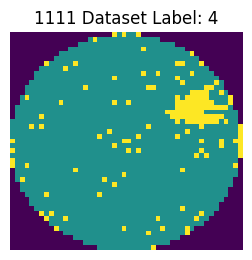

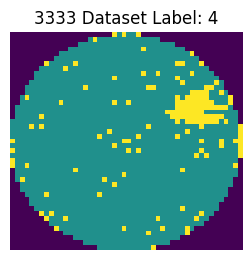

In [ ]:
import matplotlib.pyplot as plt
# 채널 확인

old_dataset = WaferDataset(df, transform=None, use_rgb=False)  # 예전처럼 흑백
xb, yb = next(iter(old_dataset))
print("xb shape:", xb.shape)    

new_dataset = WaferDataset(df, transform=None, use_rgb=True)   # RGB
xb, yb = next(iter(new_dataset))
print("xb shape:", xb.shape)    

idx = 0


x_old, y_old = old_dataset[idx]

plt.figure(figsize=(3,3))
plt.imshow(img_old)
plt.title(f"1111 Dataset Label: {y_old}")
plt.axis('off')
plt.show()


x_new, y_new = new_dataset[idx]
plt.figure(figsize=(3,3))
plt.imshow(img_new,)
plt.title(f"3333 Dataset Label: {y_new}")
plt.axis('off')
plt.show()


In [83]:
IMG_SIZE = 56
# ---------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.repeat(3, 1, 1) if t.shape[0]==1 else t),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
])

In [84]:
AE_LATENT_DIM = 32
AE_LR = 1e-3
AE_EPOCHS = 30
AE_WEIGHT_DECAY = 1e-6
BATCH_SIZE_AE = 64   # AE 학습 배치 (메모리에 따라 조정)
RANDOM_STATE = 1515

In [85]:
IMG_SIZE = 56
full_dataset = WaferDataset(df, transform=train_transform,use_rgb=True)  # train_transform이면 augmentation 없으니 OK
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE_AE, shuffle=False)
xb, yb = next(iter(full_loader))
print("xb shape:", xb.shape)   
print("Full dataset size:", len(full_dataset))

xb shape: torch.Size([64, 3, 56, 56])
Full dataset size: 25519


In [119]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2)) # 16 28 28

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2)) #32, 14, 14

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential( #16, 28, 28
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid()) # 3, 56, 56
            
    def encoder(self, x):
        encode = self.cnn_layer1(x)
        encode = self.cnn_layer2(encode)   
        return encode
    
    def decoder(self, x):
        decode = self.tran_cnn_layer1(x)
        decode = self.tran_cnn_layer2(decode)
        return decode

    def forward(self, x):
        output = self.encoder(x)
        output = self.decoder(output)
        return output 

In [87]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = ConvAutoEncoder().to(DEVICE)
print(ae)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)


In [88]:
from torchsummary import summary
summary(ae,(3,56,56), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 56, 56]             448
              ReLU-2           [64, 16, 56, 56]               0
         MaxPool2d-3           [64, 16, 28, 28]               0
            Conv2d-4           [64, 32, 28, 28]           4,640
              ReLU-5           [64, 32, 28, 28]               0
         MaxPool2d-6           [64, 32, 14, 14]               0
   ConvTranspose2d-7           [64, 16, 28, 28]           2,064
              ReLU-8           [64, 16, 28, 28]               0
   ConvTranspose2d-9            [64, 3, 56, 56]             195
          Sigmoid-10            [64, 3, 56, 56]               0
Total params: 7,347
Trainable params: 7,347
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.30
Forward/backward pass size (MB): 104.12
Params size (MB): 0.03
Estimated Tot

In [ ]:


AE_EPOCHS = 50
losses = []

for epoch in range(1, AE_EPOCHS + 1):
    print(f"\n----- AE Epoch {epoch} 시작 -----")
    ae.train()
    total_loss = 0.0
    total_samples = 0

    # tqdm으로 진행률 표시
    for xb, _ in tqdm(full_loader, desc=f"Training AE Epoch {epoch}"):
        if isinstance(xb, list):
            xb = torch.stack(xb, dim=0)
            
        xb = xb.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = ae(xb)
        loss = criterion(outputs, xb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

    epoch_loss = total_loss / total_samples
    print(f"[{epoch}] AE loss={epoch_loss:.6f}")
    print(f"----- AE Epoch {epoch} 종료 | loss={epoch_loss:.6f} -----")
    losses.append(epoch_loss)


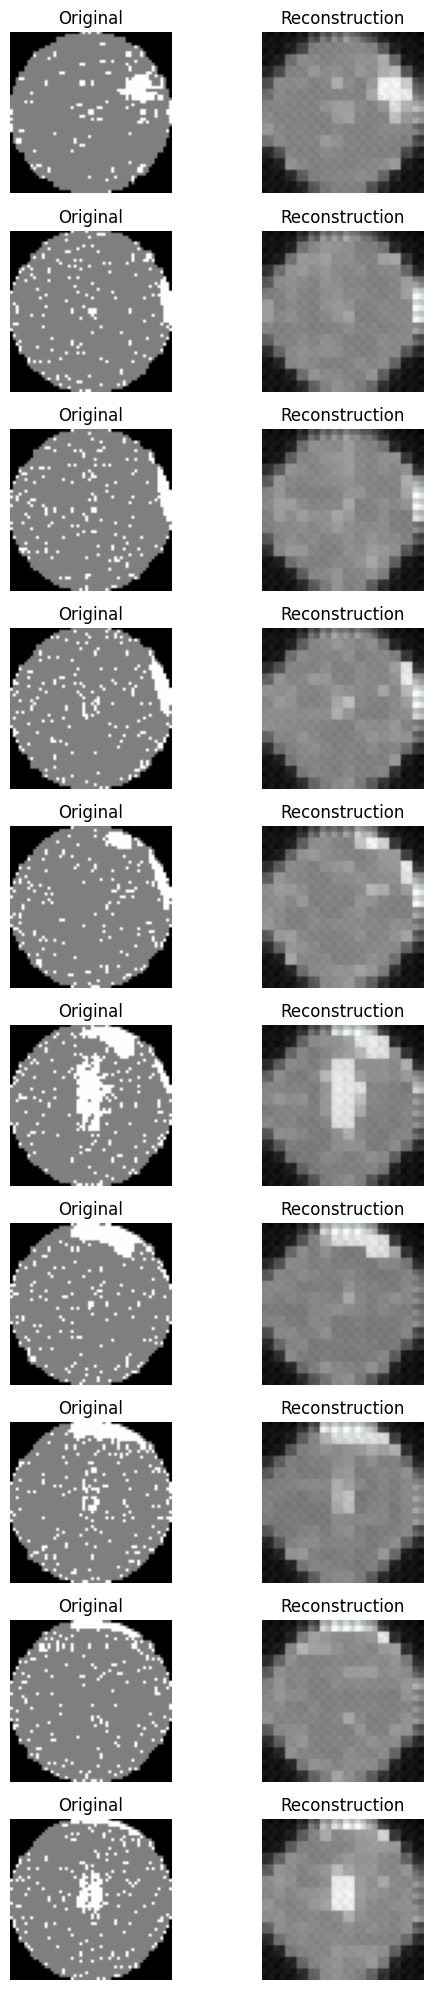

In [109]:
ae.eval()
with torch.no_grad():
    xb, _ = next(iter(full_loader))
    if isinstance(xb, list):
        xb = torch.stack(xb, dim=0)
    xb = xb.to(DEVICE, dtype=torch.float32)
    xrec = ae(xb)

# CPU로 이동
xb_np = xb.cpu().numpy()
xrec_np = xrec.cpu().numpy()

n_show = 10
fig, axes = plt.subplots(n_show, 2, figsize=(6, 2*n_show))

for i in range(n_show):
    # 원본 (그대로)
    img = xb_np[i].transpose(1,2,0)  # (C,H,W)->(H,W,C)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[i,0].imshow(img)
    axes[i,0].set_title("Original")
    axes[i,0].axis('off')
    
    # 재구성 (stretch)
    img_rec = xrec_np[i].transpose(1,2,0)
    img_rec = (img_rec - img_rec.min()) / (img_rec.max() - img_rec.min() + 1e-8)
    axes[i,1].imshow(img_rec)
    axes[i,1].set_title("Reconstruction")
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()


로스가 너무 적게 줄어서 학습이 잘 안되는거 같았지만 MSE는 픽셀 단위로해서 0-1 단위로 설정 되있으면 loss 확연하게 안 줄수도 있다는것을 알게됨 비교적 비슷하게 학습 데이터를 만드는 모습을 보여지긴함..(맞을까) 

### (1,28,28) 형태로 테스트 오토인코더 실험 

In [ ]:
IMG_SIZE = 28
# ---------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Lambda(lambda t: t.repeat(3, 1, 1) if t.shape[0]==1 else t),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
])
full_dataset = WaferDataset(df, transform=train_transform,use_rgb=False)  # train_transform이면 augmentation 없으니 OK
full_loader = DataLoader(full_dataset, batch_size=128, shuffle=False)
xb, yb = next(iter(full_loader))
print("xb shape:", xb.shape)   
print("Full dataset size:", len(full_dataset))
# -----------------------------
# 1. Autoencoder 정의
# -----------------------------
class LinearAutoencoder56(nn.Module):
    def __init__(self):
        super().__init__()
        input_dim = 28*28  # 784
        latent_dim = 64      # bottleneck

        # Encoder
        self.encoder = nn.Sequential(
                    nn.Linear(784, 500),
                    nn.ReLU(),
                    nn.Linear(500, 100),
                    nn.ReLU(),
                    nn.Linear(100, 2)  # Bottleneck layer with 2 dimensions
                )

                # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Linear(500, 784),
            nn.Sigmoid()
                )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        xrec = self.decoder(z)
        xrec = xrec.view(-1, 1, 28, 28)
        return z, xrec


xb shape: torch.Size([128, 1, 28, 28])
Full dataset size: 25519


In [61]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearAutoencoder56().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [62]:
from torchsummary import summary
summary(model,(1,28,28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [128, 500]         392,500
              ReLU-2                 [128, 500]               0
            Linear-3                 [128, 100]          50,100
              ReLU-4                 [128, 100]               0
            Linear-5                   [128, 2]             202
            Linear-6                 [128, 100]             300
              ReLU-7                 [128, 100]               0
            Linear-8                 [128, 500]          50,500
              ReLU-9                 [128, 500]               0
           Linear-10                 [128, 784]         392,784
          Sigmoid-11                 [128, 784]               0
Total params: 886,386
Trainable params: 886,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/

In [63]:
AE_EPOCHS = 50
losses = []

# -----------------------------
# 3. 학습 루프
# -----------------------------
for epoch in range(1, AE_EPOCHS+1):
    print(f"\n----- AE Epoch {epoch} 시작 -----")
    model.train()
    total_loss = 0.0
    total_samples = 0

    for xb, _ in tqdm(full_loader, desc=f"Training AE Epoch {epoch}"):
        if isinstance(xb, list):
            xb = torch.stack(xb, dim=0)

        xb = xb.float().to(DEVICE)

        optimizer.zero_grad()
        z, xrec = model(xb)
        loss = criterion(xrec, xb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

    epoch_loss = total_loss / total_samples
    print(f"[{epoch}] AE loss={epoch_loss:.6f}")
    print(f"----- AE Epoch {epoch} 종료 | loss={epoch_loss:.6f} -----")
    losses.append(epoch_loss)


----- AE Epoch 1 시작 -----


Training AE Epoch 1: 100%|██████████| 200/200 [00:09<00:00, 21.12it/s]


[1] AE loss=0.012023
----- AE Epoch 1 종료 | loss=0.012023 -----

----- AE Epoch 2 시작 -----


Training AE Epoch 2: 100%|██████████| 200/200 [00:09<00:00, 20.88it/s]


[2] AE loss=0.000018
----- AE Epoch 2 종료 | loss=0.000018 -----

----- AE Epoch 3 시작 -----


Training AE Epoch 3: 100%|██████████| 200/200 [00:10<00:00, 19.97it/s]


[3] AE loss=0.000008
----- AE Epoch 3 종료 | loss=0.000008 -----

----- AE Epoch 4 시작 -----


Training AE Epoch 4: 100%|██████████| 200/200 [00:09<00:00, 20.17it/s]


[4] AE loss=0.000003
----- AE Epoch 4 종료 | loss=0.000003 -----

----- AE Epoch 5 시작 -----


Training AE Epoch 5: 100%|██████████| 200/200 [00:09<00:00, 21.13it/s]


[5] AE loss=0.000002
----- AE Epoch 5 종료 | loss=0.000002 -----

----- AE Epoch 6 시작 -----


Training AE Epoch 6: 100%|██████████| 200/200 [00:09<00:00, 20.81it/s]


[6] AE loss=0.000002
----- AE Epoch 6 종료 | loss=0.000002 -----

----- AE Epoch 7 시작 -----


Training AE Epoch 7: 100%|██████████| 200/200 [00:09<00:00, 21.42it/s]


[7] AE loss=0.000002
----- AE Epoch 7 종료 | loss=0.000002 -----

----- AE Epoch 8 시작 -----


Training AE Epoch 8: 100%|██████████| 200/200 [00:09<00:00, 21.60it/s]


[8] AE loss=0.000002
----- AE Epoch 8 종료 | loss=0.000002 -----

----- AE Epoch 9 시작 -----


Training AE Epoch 9: 100%|██████████| 200/200 [00:09<00:00, 21.00it/s]


[9] AE loss=0.000002
----- AE Epoch 9 종료 | loss=0.000002 -----

----- AE Epoch 10 시작 -----


Training AE Epoch 10: 100%|██████████| 200/200 [00:09<00:00, 21.47it/s]


[10] AE loss=0.000002
----- AE Epoch 10 종료 | loss=0.000002 -----

----- AE Epoch 11 시작 -----


Training AE Epoch 11: 100%|██████████| 200/200 [00:09<00:00, 21.73it/s]


[11] AE loss=0.000002
----- AE Epoch 11 종료 | loss=0.000002 -----

----- AE Epoch 12 시작 -----


Training AE Epoch 12: 100%|██████████| 200/200 [00:09<00:00, 20.20it/s]


[12] AE loss=0.000002
----- AE Epoch 12 종료 | loss=0.000002 -----

----- AE Epoch 13 시작 -----


Training AE Epoch 13: 100%|██████████| 200/200 [00:09<00:00, 21.58it/s]


[13] AE loss=0.000002
----- AE Epoch 13 종료 | loss=0.000002 -----

----- AE Epoch 14 시작 -----


Training AE Epoch 14: 100%|██████████| 200/200 [00:09<00:00, 20.54it/s]


[14] AE loss=0.000002
----- AE Epoch 14 종료 | loss=0.000002 -----

----- AE Epoch 15 시작 -----


Training AE Epoch 15: 100%|██████████| 200/200 [00:08<00:00, 22.51it/s]


[15] AE loss=0.000002
----- AE Epoch 15 종료 | loss=0.000002 -----

----- AE Epoch 16 시작 -----


Training AE Epoch 16: 100%|██████████| 200/200 [00:09<00:00, 21.17it/s]


[16] AE loss=0.000002
----- AE Epoch 16 종료 | loss=0.000002 -----

----- AE Epoch 17 시작 -----


Training AE Epoch 17: 100%|██████████| 200/200 [00:09<00:00, 21.86it/s]


[17] AE loss=0.000002
----- AE Epoch 17 종료 | loss=0.000002 -----

----- AE Epoch 18 시작 -----


Training AE Epoch 18: 100%|██████████| 200/200 [00:08<00:00, 22.92it/s]


[18] AE loss=0.000002
----- AE Epoch 18 종료 | loss=0.000002 -----

----- AE Epoch 19 시작 -----


Training AE Epoch 19: 100%|██████████| 200/200 [00:09<00:00, 22.07it/s]


[19] AE loss=0.000002
----- AE Epoch 19 종료 | loss=0.000002 -----

----- AE Epoch 20 시작 -----


Training AE Epoch 20: 100%|██████████| 200/200 [00:08<00:00, 22.23it/s]


[20] AE loss=0.000002
----- AE Epoch 20 종료 | loss=0.000002 -----

----- AE Epoch 21 시작 -----


Training AE Epoch 21: 100%|██████████| 200/200 [00:09<00:00, 20.88it/s]


[21] AE loss=0.000002
----- AE Epoch 21 종료 | loss=0.000002 -----

----- AE Epoch 22 시작 -----


Training AE Epoch 22: 100%|██████████| 200/200 [00:09<00:00, 21.57it/s]


[22] AE loss=0.000002
----- AE Epoch 22 종료 | loss=0.000002 -----

----- AE Epoch 23 시작 -----


Training AE Epoch 23: 100%|██████████| 200/200 [00:09<00:00, 21.86it/s]


[23] AE loss=0.000002
----- AE Epoch 23 종료 | loss=0.000002 -----

----- AE Epoch 24 시작 -----


Training AE Epoch 24: 100%|██████████| 200/200 [00:08<00:00, 22.71it/s]


[24] AE loss=0.000002
----- AE Epoch 24 종료 | loss=0.000002 -----

----- AE Epoch 25 시작 -----


Training AE Epoch 25: 100%|██████████| 200/200 [00:09<00:00, 22.22it/s]


[25] AE loss=0.000002
----- AE Epoch 25 종료 | loss=0.000002 -----

----- AE Epoch 26 시작 -----


Training AE Epoch 26: 100%|██████████| 200/200 [00:08<00:00, 22.75it/s]


[26] AE loss=0.000002
----- AE Epoch 26 종료 | loss=0.000002 -----

----- AE Epoch 27 시작 -----


Training AE Epoch 27: 100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


[27] AE loss=0.000002
----- AE Epoch 27 종료 | loss=0.000002 -----

----- AE Epoch 28 시작 -----


Training AE Epoch 28: 100%|██████████| 200/200 [00:09<00:00, 21.30it/s]


[28] AE loss=0.000002
----- AE Epoch 28 종료 | loss=0.000002 -----

----- AE Epoch 29 시작 -----


Training AE Epoch 29: 100%|██████████| 200/200 [00:09<00:00, 21.04it/s]


[29] AE loss=0.000002
----- AE Epoch 29 종료 | loss=0.000002 -----

----- AE Epoch 30 시작 -----


Training AE Epoch 30: 100%|██████████| 200/200 [00:08<00:00, 22.72it/s]


[30] AE loss=0.000002
----- AE Epoch 30 종료 | loss=0.000002 -----

----- AE Epoch 31 시작 -----


Training AE Epoch 31: 100%|██████████| 200/200 [00:08<00:00, 22.78it/s]


[31] AE loss=0.000002
----- AE Epoch 31 종료 | loss=0.000002 -----

----- AE Epoch 32 시작 -----


Training AE Epoch 32: 100%|██████████| 200/200 [00:08<00:00, 23.23it/s]


[32] AE loss=0.000002
----- AE Epoch 32 종료 | loss=0.000002 -----

----- AE Epoch 33 시작 -----


Training AE Epoch 33: 100%|██████████| 200/200 [00:08<00:00, 22.83it/s]


[33] AE loss=0.000002
----- AE Epoch 33 종료 | loss=0.000002 -----

----- AE Epoch 34 시작 -----


Training AE Epoch 34: 100%|██████████| 200/200 [00:08<00:00, 22.78it/s]


[34] AE loss=0.000002
----- AE Epoch 34 종료 | loss=0.000002 -----

----- AE Epoch 35 시작 -----


Training AE Epoch 35: 100%|██████████| 200/200 [00:09<00:00, 22.06it/s]


[35] AE loss=0.000002
----- AE Epoch 35 종료 | loss=0.000002 -----

----- AE Epoch 36 시작 -----


Training AE Epoch 36: 100%|██████████| 200/200 [00:09<00:00, 21.34it/s]


[36] AE loss=0.000002
----- AE Epoch 36 종료 | loss=0.000002 -----

----- AE Epoch 37 시작 -----


Training AE Epoch 37: 100%|██████████| 200/200 [00:09<00:00, 22.19it/s]


[37] AE loss=0.000002
----- AE Epoch 37 종료 | loss=0.000002 -----

----- AE Epoch 38 시작 -----


Training AE Epoch 38: 100%|██████████| 200/200 [00:09<00:00, 21.40it/s]


[38] AE loss=0.000002
----- AE Epoch 38 종료 | loss=0.000002 -----

----- AE Epoch 39 시작 -----


Training AE Epoch 39: 100%|██████████| 200/200 [00:08<00:00, 22.53it/s]


[39] AE loss=0.000002
----- AE Epoch 39 종료 | loss=0.000002 -----

----- AE Epoch 40 시작 -----


Training AE Epoch 40: 100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


[40] AE loss=0.000002
----- AE Epoch 40 종료 | loss=0.000002 -----

----- AE Epoch 41 시작 -----


Training AE Epoch 41: 100%|██████████| 200/200 [00:08<00:00, 22.89it/s]


[41] AE loss=0.000002
----- AE Epoch 41 종료 | loss=0.000002 -----

----- AE Epoch 42 시작 -----


Training AE Epoch 42: 100%|██████████| 200/200 [00:08<00:00, 23.03it/s]


[42] AE loss=0.000002
----- AE Epoch 42 종료 | loss=0.000002 -----

----- AE Epoch 43 시작 -----


Training AE Epoch 43: 100%|██████████| 200/200 [00:08<00:00, 23.06it/s]


[43] AE loss=0.000002
----- AE Epoch 43 종료 | loss=0.000002 -----

----- AE Epoch 44 시작 -----


Training AE Epoch 44: 100%|██████████| 200/200 [00:08<00:00, 23.30it/s]


[44] AE loss=0.000002
----- AE Epoch 44 종료 | loss=0.000002 -----

----- AE Epoch 45 시작 -----


Training AE Epoch 45: 100%|██████████| 200/200 [00:08<00:00, 22.71it/s]


[45] AE loss=0.000002
----- AE Epoch 45 종료 | loss=0.000002 -----

----- AE Epoch 46 시작 -----


Training AE Epoch 46: 100%|██████████| 200/200 [00:08<00:00, 22.24it/s]


[46] AE loss=0.000002
----- AE Epoch 46 종료 | loss=0.000002 -----

----- AE Epoch 47 시작 -----


Training AE Epoch 47: 100%|██████████| 200/200 [00:09<00:00, 21.37it/s]


[47] AE loss=0.000002
----- AE Epoch 47 종료 | loss=0.000002 -----

----- AE Epoch 48 시작 -----


Training AE Epoch 48: 100%|██████████| 200/200 [00:09<00:00, 20.27it/s]


[48] AE loss=0.000002
----- AE Epoch 48 종료 | loss=0.000002 -----

----- AE Epoch 49 시작 -----


Training AE Epoch 49: 100%|██████████| 200/200 [00:09<00:00, 21.75it/s]


[49] AE loss=0.000002
----- AE Epoch 49 종료 | loss=0.000002 -----

----- AE Epoch 50 시작 -----


Training AE Epoch 50: 100%|██████████| 200/200 [00:09<00:00, 20.52it/s]

[50] AE loss=0.000002
----- AE Epoch 50 종료 | loss=0.000002 -----


In [ ]:
## 그림 
model.eval()
with torch.no_grad():
    xb, _ = next(iter(full_loader))
    if isinstance(xb, list):
        xb = torch.stack(xb, dim=0)
    xb = xb.to(DEVICE, dtype=torch.float32)
    z,xrec = model(xb)

# CPU로 이동
xb_np = xb.cpu().numpy()
xrec_np = xrec.cpu().numpy()


n_show = 10  # 보여줄 이미지 수
fig, axes = plt.subplots(n_show, 2, figsize=(6, 2*n_show))  # n_show x 2 배열: 원본 / 재구성

for i in range(n_show):
    # 원본 이미지
    img_orig = xb_np[i,0]  # (1,56,56) -> 0번째 채널 선택
    # 값이 0~1 범위가 아닐 수도 있으니 정규화

    
    axes[i,0].imshow(img_orig, cmap='gray')
    axes[i,0].set_title("Original")
    axes[i,0].axis('off')
    
    # 재구성 이미지
    img_rec = xrec_np[i,0]  # (1,56,56) -> 0번째 채널 선택
    #img_rec = (img_rec - img_rec.min()) / (img_rec.max() - img_rec.min() + 1e-8)  # stretch
    axes[i,1].imshow(img_rec, cmap='gray')
    axes[i,1].set_title("Reconstruction")
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# z 변수 가져오기 

def extract_all_latents_safe(model, df, batch=32, transform=None, device=None):

    # --- sanity device check ---
    if device is None:
        # try to get device from model parameters
        try:
            device = next(model.parameters()).device
        except StopIteration:
            device = torch.device("cpu")
    if verbose:
        print("Extract latents on device:", device)

    model.eval()
    zs = []
    ys = []

    ds = WaferDataset(df, transform=transform)  # transform should produce tensors [C,H,W]
    loader = DataLoader(ds, batch_size=batch, shuffle=False)

    if len(ds) == 0:
        raise ValueError("Dataset is empty (len(df)==0).")

    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Extract latents", leave=True):
            # ensure xb is float tensor and on correct device
            if not torch.is_tensor(xb):
                xb = torch.tensor(xb, dtype=torch.float32)
            xb = xb.to(device)
            # encode
            try:
                z = model.encode(xb)   # expected shape [B, latent_dim]
            except Exception as e:
                # give actionable message
                raise RuntimeError(f"model.encode failed on input shape {xb.shape}: {e}")

            # move to cpu numpy
            zs.append(z.detach().cpu().numpy())
            ys.append(yb.numpy())

    if len(zs) == 0:
        raise RuntimeError("No latents were collected (zs is empty). Check DataLoader and dataset transforms.")

    Z_all = np.concatenate(zs, axis=0)
    y_all = np.concatenate(ys, axis=0)

    if verbose:
        print("Extracted latents:", Z_all.shape, "labels:", y_all.shape)
        # basic checks
        if np.isnan(Z_all).any():
            print("Warning: NaNs found in latent vectors.")
        if np.isinf(Z_all).any():
            print("Warning: Infs found in latent vectors.")
    return Z_all, y_all


In [118]:
Z_all, y_all = extract_all_latents_safe(ae, df, batch=64, transform=train_transform, device=DEVICE)

Extract latents on device: cuda


Extract latents:   0%|          | 0/399 [00:00<?, ?it/s]


RuntimeError: model.encode failed on input shape torch.Size([64, 3, 56, 56]): 'ConvAutoEncoder' object has no attribute 'encode'